## Variational Autoencoders on Poor Sevens

Import Libraries

In [1]:
import pickle
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

Load data

In [2]:
with open('hw4_tr7.pkl', 'rb') as f:
    tr_data = pickle.load(f)
print(tr_data.shape)
with open('hw4_te7.pkl', 'rb') as f:
    te_data = pickle.load(f)
print(te_data.shape)

(6265, 28, 28)
(1028, 28, 28)


In [3]:
tr_data = np.reshape(tr_data, (len(tr_data), 28, 28, 1))
te_data = np.reshape(te_data, (len(te_data), 28, 28, 1))

Define number of latent dimensions

In [4]:
latent_dim = 4

Encoder network:

In [5]:
#https://blog.keras.io/building-autoencoders-in-keras.html
def encoder(ip):
    with tf.variable_scope("Encoder"):
        print("input", ip.shape)
        conv1 = tf.layers.conv2d(ip, filters = 16, kernel_size=(4,4), activation="tanh", kernel_initializer = tf.contrib.layers.xavier_initializer(),padding = "same")
        print("conv1",conv1.shape)
        maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides =4)
        print("maxpool1",maxpool1.shape)
        conv2 = tf.layers.conv2d(maxpool1, filters = 32, kernel_size=(2,2), activation="tanh",kernel_initializer = tf.contrib.layers.xavier_initializer(), padding = "same")
        print("conv2",conv2.shape)
        maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides =4)
        print("maxpool2",maxpool2.shape)
        flatten1 = tf.layers.flatten(maxpool2)
        print("flatten",flatten1.shape)

        mean = tf.layers.dense(flatten1, units = latent_dim)
        print("mean",mean.shape)

        std_dev = tf.layers.dense(flatten1, units = latent_dim)
        print("std_dev",std_dev.shape)

        return  mean, std_dev

Decoder network:

In [6]:
def decoder(ip):
    with tf.variable_scope("Decoder"):
        dense1_decoder = tf.layers.dense(ip, units = 128  , activation ="tanh", kernel_initializer = tf.contrib.layers.xavier_initializer()) 
        print("dense1_decoder", dense1_decoder.shape)

        reshaped = tf.reshape(dense1_decoder, [-1, 4, 4, 8])
        print("reshaped", reshaped.shape)

        conv1_decoder = tf.layers.conv2d_transpose(reshaped, filters=8, kernel_size=(3,3), strides = (1,1), padding='same', activation='tanh',kernel_initializer = tf.contrib.layers.xavier_initializer())
        print("conv1_decoder",conv1_decoder.shape)

        conv2_decoder = tf.layers.conv2d_transpose(conv1_decoder, filters=8, kernel_size=(3,3), strides = (2,2), padding='same', activation='tanh', kernel_initializer = tf.contrib.layers.xavier_initializer())
        print("conv2_decoder",conv2_decoder.shape)

        conv3_decoder = tf.layers.conv2d_transpose(conv2_decoder, filters=16, kernel_size=(3,3), strides = (2,2), padding='same', activation='tanh', kernel_initializer = tf.contrib.layers.xavier_initializer())
        print("conv3_decoder",conv3_decoder.shape)

        flatten1_decoder = tf.layers.flatten(conv3_decoder)
        print("flatten1_decoder", flatten1_decoder.shape)

        dense2_decoder = tf.layers. dense(flatten1_decoder, units=28 * 28, activation=None)
        print("dense2_decoder", dense2_decoder.shape)

        dense3_decoder = tf.layers.dense(dense2_decoder, units=28 * 28, activation=tf.nn.sigmoid)
        print("dense3_decoder", dense3_decoder.shape)

        img = tf.reshape(dense3_decoder, shape=[-1, 28, 28, 1])
        print("img", img.shape)
        return img

For the network, I used latent loss(encoder) added with MSE(decoder). For the latent loss, I multiplied it with a beta value of 1/784 to scale with the size of our images.

In [7]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32,[None,28,28,1])
mean_, std_dev_ = encoder(x)

#latent loss
latent_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1.0 + (2*std_dev_) - tf.square(mean_) - tf.exp(2*std_dev_), 1))
##reparametrization trick
epsilon = tf.random_normal(tf.stack([tf.shape(mean_)[0], latent_dim])) 
encoded_img = (epsilon * tf.exp(std_dev_)) + mean_

decoded_img = decoder(encoded_img)

mse_loss=tf.losses.mean_squared_error(x,decoded_img) 
#https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#beta-vae
beta =1/784
final_loss = mse_loss + beta*latent_loss

input (?, 28, 28, 1)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
conv1 (?, 28, 28, 16)
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
maxpool1 (?, 7, 7, 16)
conv2 (?, 7, 7, 32)
maxpool2 (?, 2, 2, 32)
Instructions for updating:
Use keras.layers.flatten instead.
flatten (?, 128)
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
mean (?, 4)
std_dev (?, 4)
dense1_decoder (?, 128)
reshaped (?, 4, 4, 8)
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` ins

The network uses Adam optimizer with a learning rate of 0.0001 and is ran for 50 epochs.

In [8]:
optimizer = tf.train.AdamOptimizer(0.0001).minimize(final_loss)

epochs = 50
batch_size = 7
batches=int(tr_data.shape[0]/batch_size)
init = tf.global_variables_initializer()

In [9]:
# writer = tf.summary.FileWriter('./a42graph', graph = tf.get_default_graph())
# writer.close()

In [10]:
# print(batches)
# for batch in range(batches):
#     print(batch*35, (batch+1) *35)

In [11]:
sess_a4_2 = tf.Session()   
sess_a4_2.run(init)

for epoch in range(epochs):
    batch_loss = 0
    lloss=0
    mloss=0
    for batch in range(batches):
        loss,_ = sess_a4_2.run([final_loss, optimizer], feed_dict = {x:tr_data[batch*batch_size : (batch+1) * batch_size]} )
        batch_loss += loss

    print("epoch", epoch, "loss", batch_loss/batches)

epoch 0 loss 0.07171242676633696
epoch 1 loss 0.05876983483243921
epoch 2 loss 0.054377226007051305
epoch 3 loss 0.04967770624343909
epoch 4 loss 0.04853286546701825
epoch 5 loss 0.04778533340249648
epoch 6 loss 0.046982696356886594
epoch 7 loss 0.04629925640518439
epoch 8 loss 0.04575489957156128
epoch 9 loss 0.045403223959260816
epoch 10 loss 0.04495493624380181
epoch 11 loss 0.04440426893906886
epoch 12 loss 0.04408759025430213
epoch 13 loss 0.043671495509047746
epoch 14 loss 0.043324489398292323
epoch 15 loss 0.042882341017436716
epoch 16 loss 0.042556219437685096
epoch 17 loss 0.04235037638280312
epoch 18 loss 0.042032550556283424
epoch 19 loss 0.04186906694699932
epoch 20 loss 0.041669292962334674
epoch 21 loss 0.041486528155773715
epoch 22 loss 0.04131980702572362
epoch 23 loss 0.04110773183696763
epoch 24 loss 0.04098101606249143
epoch 25 loss 0.04080140547379435
epoch 26 loss 0.04061176571890961
epoch 27 loss 0.04051152269392373
epoch 28 loss 0.040223757190078334
epoch 29 loss

In [12]:
len(np.arange(-5,5.5,0.5))

21

In [13]:
def generate_samples(which_dim):
    size=21
    codes=np.zeros((size,latent_dim))    
    for i in range(latent_dim):
        if i == which_dim:
            codes[:,i]=np.arange(-5,5.5,0.5)
        else:
            codes[:,i]=np.repeat(np.random.normal(0,1),size)
    return codes
final_codes = []
for i in range(latent_dim):
    final_codes.append(generate_samples(i))

In [14]:
final_imgs = []
for i in range(latent_dim):
    final_imgs.append(sess_a4_2.run(decoded_img, feed_dict = {encoded_img: final_codes[i]}))

In [15]:
np.array(final_imgs).shape

(4, 21, 28, 28, 1)

In [16]:
final_imgs[0].shape

(21, 28, 28, 1)

In [17]:
#https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
def plot_fig(imgs):
    fig=plt.figure(figsize=(15, 15))
    columns = 7
    rows = 3
    print(imgs.shape)
    for i in range(1,22):
        img = imgs[i-1]
        img = np.reshape(img, [28, 28])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap=plt.cm.binary)
    plt.show()

Dimension 1 / 4
(21, 28, 28, 1)


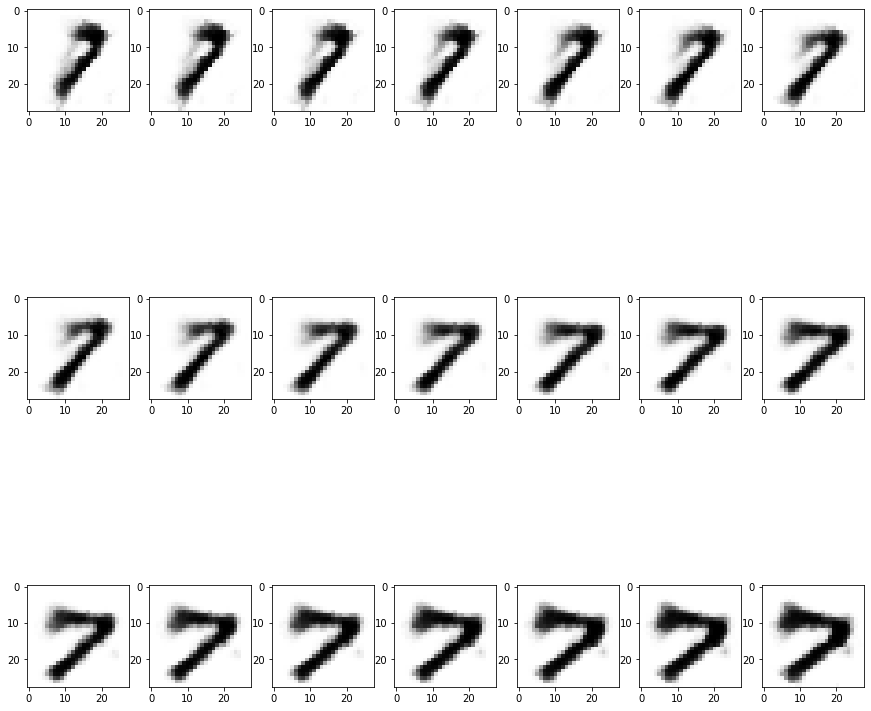

In [18]:
print("Dimension", 1,'/',latent_dim)
plot_fig(final_imgs[0])

Dimension 2 / 4
(21, 28, 28, 1)


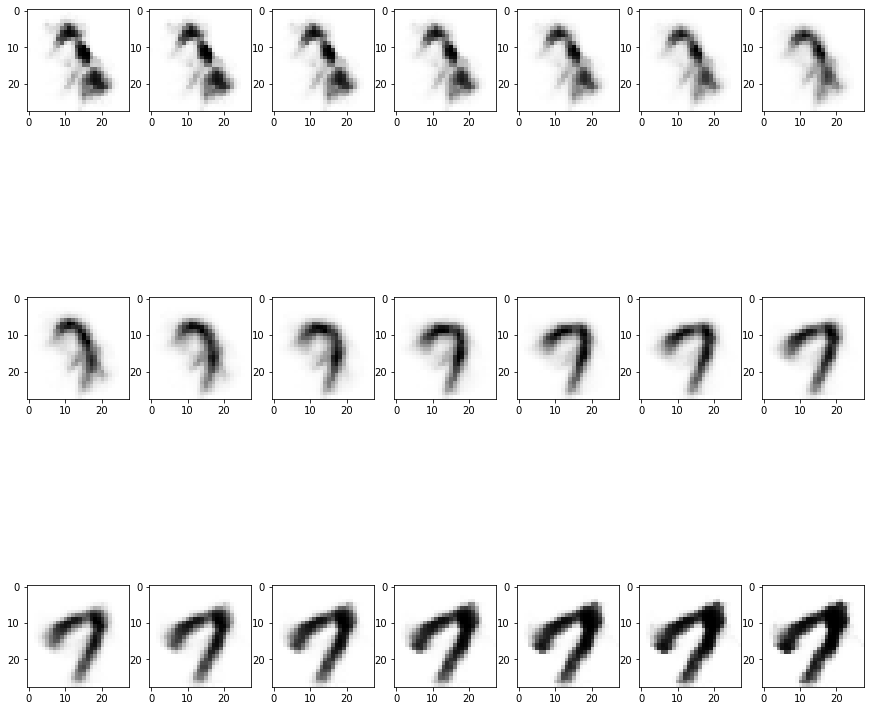

In [19]:
print("Dimension", 2,'/',latent_dim)
plot_fig(final_imgs[1])

Dimension 3 / 4
(21, 28, 28, 1)


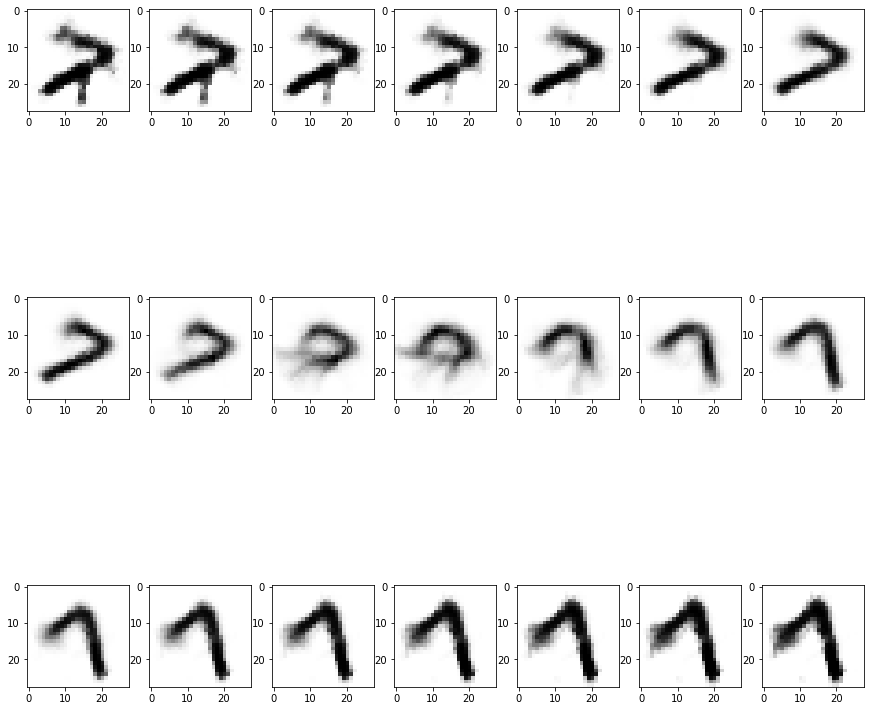

In [21]:
print("Dimension", 3,'/',latent_dim)
plot_fig(final_imgs[2])

Dimension 4 / 4
(21, 28, 28, 1)


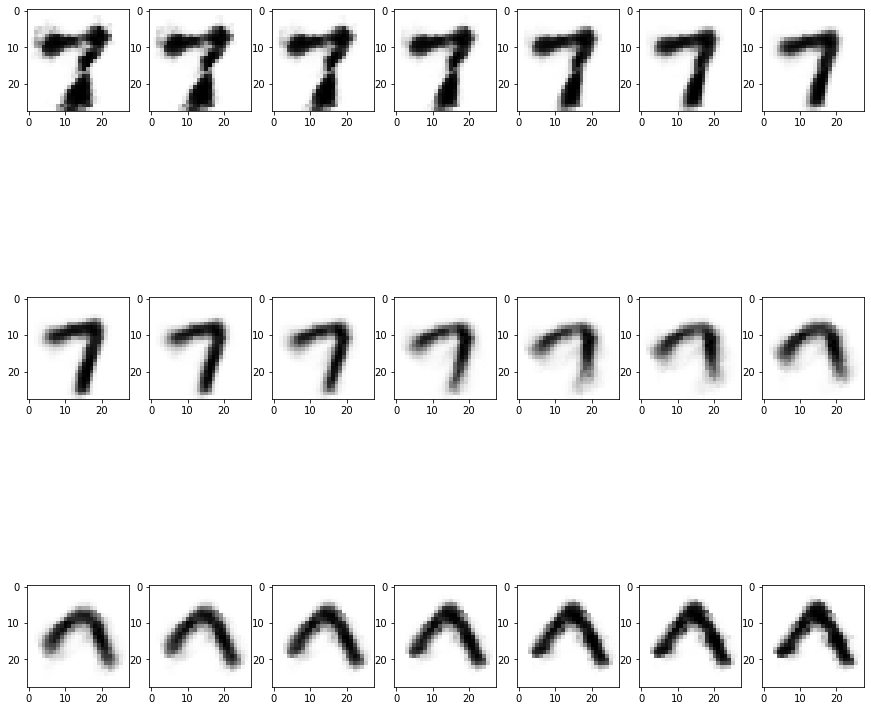

In [22]:
print("Dimension", 4,'/',latent_dim)
plot_fig(final_imgs[3])